# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from darts import TimeSeries
from darts.metrics import mape, r2_score, rmse

import utils



def prepare_data():
    df = utils.load_data()
    ts, covars_diff, covars_nodiff = utils.df2ts(df)
    covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True)
    covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(
        covars_nodiff, should_diff=False
    )
    pipeline, ts_scaled = utils.scale_ts(ts, should_diff=False)

    train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
    train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))

    covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled)
    train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(
        pd.Timestamp("2016-01-01")
    )

    # Define the training and validation sets
    train = train_ts_scaled.pd_dataframe()
    validation = val_ts_scaled.pd_dataframe()
    history = pd.concat([train, validation])

    return train, validation, history, pipeline, ts_scaled, val_ts, covariates_scaled

# AR Model

In [2]:
train, validation, history, pipeline, ts_scaled, val_ts, _ = prepare_data()


<Axes: xlabel='DATE'>

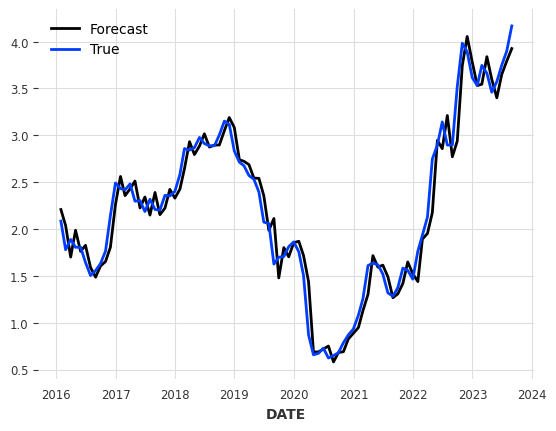

In [3]:
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Compute the optimal lag order on the training set
sel = ar_select_order(train, 12, old_names=False, glob=True)


# For each time step in the validation set, fit a new model on the history so far and predict the next step
forecasts = pd.DataFrame()
for t in validation.index:

     # Get the history up to the previous month
    hist_t = history[:t - pd.offsets.MonthEnd()]
    # print(hist_t.iloc[-1])

    # Fit the model with data up to the previous month using the optimal lag order
    model = AutoReg(hist_t, lags=sel.ar_lags, old_names=False)
    model_fit = model.fit(cov_type="HC0")

    # Forecast for t + 1
    model_fit = model_fit.append(validation[t:t])
    y_pred = model_fit.get_prediction(start=-1)
    # print(y_pred.summary_frame())

    # Append the forecast to the list of forecasts
    forecasts = pd.concat([forecasts, y_pred.summary_frame()])

# Revert the scaling
fore_unscaled = utils.unscale_series(TimeSeries.from_dataframe(forecasts, value_cols=["mean"]), pipeline, ts_scaled)

# Plot the forecast
fore_unscaled.plot(label="Forecast")
val_ts.plot(label="True")

In [4]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:      US_TB_YIELD_10YRS   No. Observations:                  523
Model:                     AutoReg(3)   Log Likelihood                 570.633
Method:               Conditional MLE   S.D. of innovations              0.081
Date:                Fri, 03 Jan 2025   AIC                          -1131.267
Time:                        22:06:23   BIC                          -1109.997
Sample:                    05-31-1980   HQIC                         -1122.935
                         - 08-31-2023                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0033      0.004     -0.945      0.345      -0.010       0.004
US_TB_YIELD_10YRS.L1     1.3593      0.067     20.354      0.000       1.228       1.490
US_TB_YIELD_10YRS.L2    -0.5281      0.108     -4.891      0.000      -0.740      -0.316
US_TB_YIELD_10YRS.L3     0.1628      0.059      2.742      0.006       0.046       0.279
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0075           -0.0000j            1.0075           -0.0000
AR.2            1.1181           -2.2015j            2.4692           -0.1752
AR.3            1.1181           +2.2015j            2.4692            0.1752
-----------------------------------------------------------------------------

Parameters and standard errors were estimated using a different dataset and were then applied to this dataset.
"""

In [5]:
# Compute the error metrics
print(f"MAPE: {mape(val_ts, fore_unscaled)}")
print(f"RMSE: {rmse(val_ts, fore_unscaled)}")
print(f"R2: {r2_score(val_ts, fore_unscaled)}")

MAPE: 7.2241754502967295
RMSE: 0.18459669791030714
R2: 0.9562454123627405


In [15]:
# fig = model_fit.plot_diagnostics(lags=24)

# VAR Model

In [7]:
## IGNORE BELOW: Poutine pour formater les données pour VAR

train, validation, history, pipeline, ts_scaled, val_ts, covariates_scaled = prepare_data()

# Only CPI seems to be significant
ONLY_CPI = True


# VAR only works with multivariate time series, so we add the covariates to the yield time series
if ONLY_CPI:
    ts_scaled = ts_scaled.stack(covariates_scaled["US_CPI"])
else:
    ts_scaled = ts_scaled.stack(covariates_scaled)


history = ts_scaled.pd_dataframe()
train = history[: pd.Timestamp("2016-01-01")]
validation = history[pd.Timestamp("2016-01-01") :]

<Axes: xlabel='DATE'>

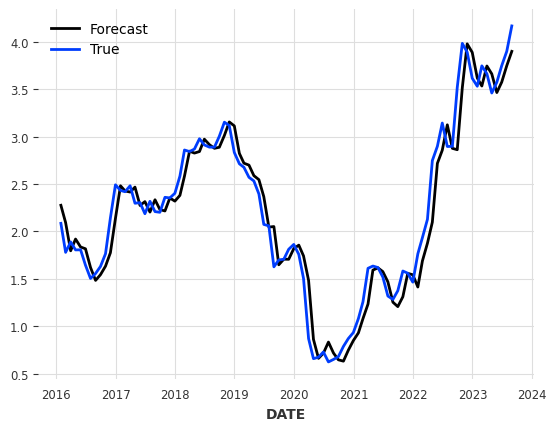

In [ ]:
# For each time step in the validation set, fit a new model on the history so far and predict the next step
forecasts = pd.DataFrame()
for t in validation.index:

    # Get the history up to the previous month
    hist_t = history[:t - pd.offsets.MonthEnd()]
    # print(hist_t.iloc[-1])

    # Fit the model with data up to the previous month
    model = VAR(hist_t)
    model_fit = model.fit()

    # Forecast for t + 1
    y_pred = model_fit.forecast(hist_t.values[-model_fit.k_ar:], steps=1)[0][0]
    # print(y_pred.summary_frame())
    forecasts = pd.concat([forecasts, pd.DataFrame([y_pred], columns=["mean"], index=[t])])

# Revert the scaling
fore_unscaled = utils.unscale_series(TimeSeries.from_dataframe(forecasts, value_cols=["mean"]), pipeline, ts_scaled["US_TB_YIELD_10YRS"])

# Plot the forecast
fore_unscaled.plot(label="Forecast")
val_ts.plot(label="True")

In [10]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 03, Jan, 2025
Time:                     22:06:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.50259
Nobs:                     521.000    HQIC:                  -5.53240
Log likelihood:          -26.3431    FPE:                 0.00388126
AIC:                     -5.55160    Det(Omega_mle):      0.00383694
--------------------------------------------------------------------
Results for equation US_TB_YIELD_10YRS
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.004865         0.003864           -1.259           0.208
L1.US_TB_YIELD_10YRS         0.992566         0.003864          256.878           0.000
L1.US_CPI           

In [11]:
# Compute the error metrics
print(f"MAPE: {mape(val_ts, fore_unscaled)}")
print(f"RMSE: {rmse(val_ts, fore_unscaled)}")
print(f"R2: {r2_score(val_ts, fore_unscaled)}")

MAPE: 8.22840873976322
RMSE: 0.20626381890041642
R2: 0.9453711764782448


In [12]:
model_fit.test_normality()

In [13]:
model_fit.test_whiteness()

In [14]:
test_result = model_fit.test_causality(caused='US_TB_YIELD_10YRS', causing=['US_CPI'], kind='f', signif=0.05)
test_result.summary()

Test statistic,Critical value,p-value,df
0.07402,3.850,0.786,"(1, 1036)"


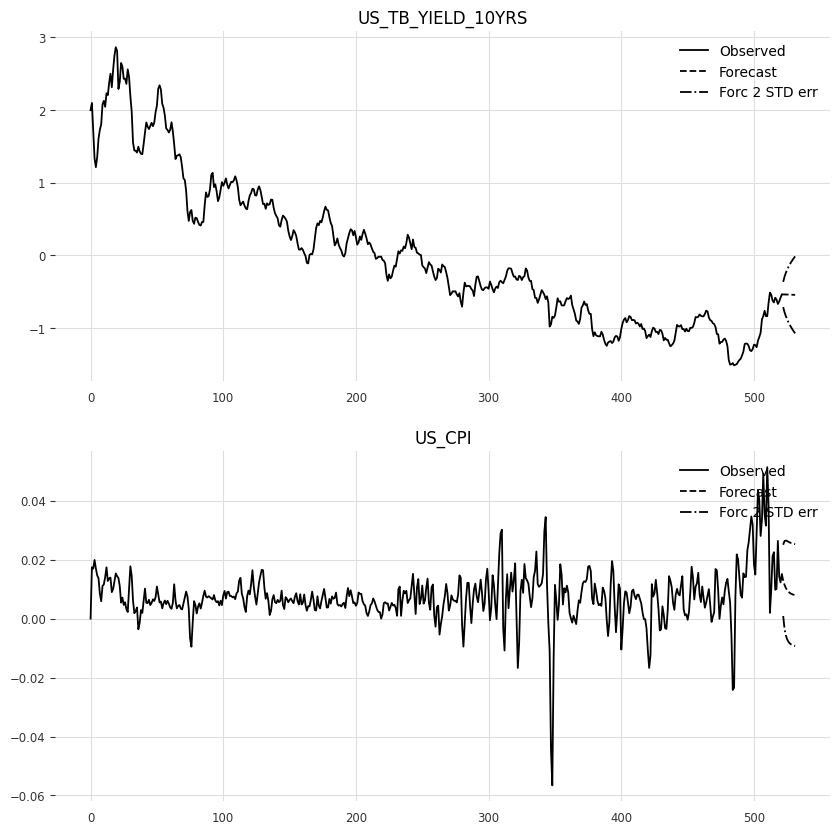

In [12]:
fig = model_fit.plot_forecast(10)